# Investigate required values

Investigate which values are needed to predict in order to fully specify a protein correctly

In [1]:
import os, sys
import functools
import itertools
import multiprocessing
import warnings
import importlib
import tempfile
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import py3Dmol

import torch

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "protdiff")
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import datasets
import angles_and_coords as ac
import nerf
import tmalign  # So we can compare structural similarity

datasets.LOCAL_DATA_DIR

PosixPath('/home/t-kevinwu/protdiff/data')

In [2]:
# Define some simple structures
sample_structures = [
    datasets.LOCAL_DATA_DIR / "1CRN.pdb",
]
assert all([s.exists() for s in sample_structures])
len(sample_structures)

1

In [3]:
def view_pdb(fname:str):
    """
    View a PDB file in a Jupyter notebook
    See: https://william-dawson.github.io/using-py3dmol.html
    """
    with open(fname) as source:
        system = "".join([l for l in source])
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(system)
    # view.setStyle({'chain': -1}, {"cartoon": {'color': 'blue'}})
    # view.setStyle({"model": -1}, {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    # view.setStyle({"cartoon": {"color":"blue"}})
    view.setStyle({"stick": {}})
    view.zoomTo()
    view.show()

view_pdb(sample_structures[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
all_ft_train_dset = datasets.CathCanonicalAnglesDataset(split='train')
all_ft_train_dset

In [5]:
importlib.reload(ac)
importlib.reload(nerf)

# https://arxiv.org/pdf/2205.04676.pdf
# N:CA:C = tau

# Full spec should be angles_to_use=["N:CA:C", "CA:C:1N", "C:1N:1CA", "phi", "psi", "omega"], dists_to_use=["N:CA", "CA:C", "C:1N"]

def test_consistency(fname:str, angles_to_use=["phi", "psi", "omega", "tau", "CA:C:1N", "C:1N:1CA"], dists_to_use=["0C:1N", "N:CA", "CA:C"], visualize:bool=False):
    """Test the consistency of reconstructing a pdb file"""
    # Create the internal coordinates
    angles = ac.canonical_distances_and_dihedrals(fname, distances=dists_to_use, angles=angles_to_use)
    if angles is None:
        return -1.0
    with tempfile.TemporaryDirectory() as dirname:
        out_fname = os.path.join(dirname, "rebuilt_" + os.path.basename(fname))
        # rebuilt = ac.create_new_chain(
        #     out_fname, angles,
        #     angles_to_set=angles_to_use, distances_to_set=dists_to_use
        # )
        out_fname_written = ac.create_new_chain_nerf(out_fname, angles, angles_to_set=angles_to_use, dists_to_set=dists_to_use)
        if not out_fname_written:  # Failed on the way, should have returned empty string ""
            return -1.0
        score = tmalign.run_tmalign(fname, out_fname)
        # angles_new = ac.canonical_distances_and_dihedrals(out_fname, distances=dists_to_use, angles=angles_to_use)
        if visualize:
            view_pdb(out_fname)
    return score

test_consistency(sample_structures[0], visualize=True)

/home/t-kevinwu/miniconda3/envs/protdiff/lib/python3.8/site-packages/biotite/structure/util.py:47: RuntimeWarning: invalid value encountered in true_divide
  v /= factor[..., np.newaxis]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

1.0

## Define the training dataset and look at reconstruction within there

In [6]:
train_dset = datasets.CathCanonicalAnglesDataset(
    split='train',
    zero_center=True,
)
len(train_dset.filenames)

24316

In [7]:
# Look at the full defined set, or 4 angles we currently fit, or 3 dihedrals

angle_sets_to_evaluate = [
    ["phi", "psi", "omega", "tau", "CA:C:1N", "C:1N:1CA"],
    ["phi", "psi", "omega", "tau"], 
    ["phi", "psi", "omega"],
]

# Look at either all the distances or none of them
dist_sets_to_evaluate = [
    ["0C:1N", "N:CA", "CA:C"],
    []
]

# Combinatorially look at these angle sets
def evaluate_angle_set_parallel(filenames, angles, dists):
    warnings.filterwarnings('ignore', '.*elements were guessed from atom_name.*')
    warnings.filterwarnings('ignore', '.*invalid value encountered in true_div.*')
    pfunc = functools.partial(
        test_consistency,
        angles_to_use=angles,
        dists_to_use=dists,
    )
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    tm_scores = np.array(list(pool.map(pfunc, filenames, chunksize=20)))
    pool.close()
    pool.join()
    # tm_scores = np.array(list(map(pfunc, filenames)))
    return tm_scores

per_angle_dist_results = {}
for a, d in itertools.product(angle_sets_to_evaluate, dist_sets_to_evaluate):
    print(a, d)
    per_angle_dist_results[tuple(a), tuple(d)] = evaluate_angle_set_parallel(train_dset.filenames[:2000], angles=a, dists=d)

['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] ['0C:1N', 'N:CA', 'CA:C']


['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] []


['phi', 'psi', 'omega', 'tau'] ['0C:1N', 'N:CA', 'CA:C']


['phi', 'psi', 'omega', 'tau'] []


['phi', 'psi', 'omega'] ['0C:1N', 'N:CA', 'CA:C']


['phi', 'psi', 'omega'] []


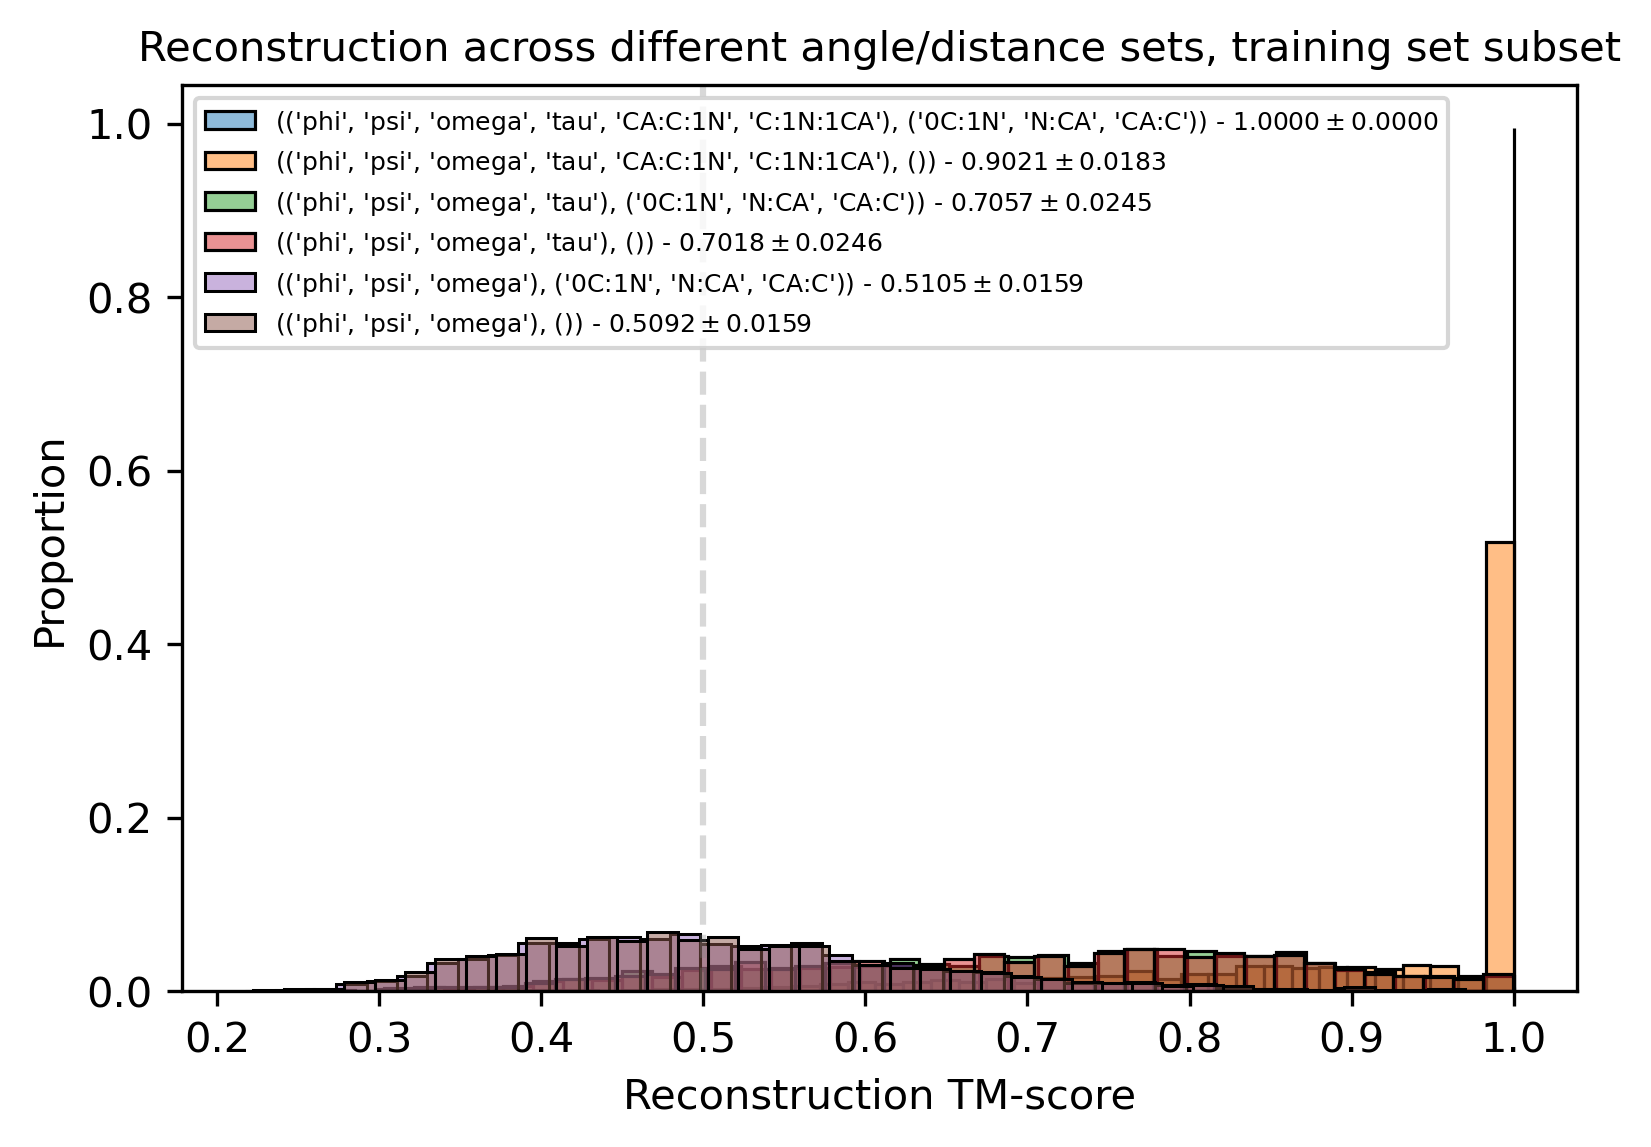

In [22]:
# Plot these results
fig, ax = plt.subplots(dpi=300)
for i, (k, v) in enumerate(per_angle_dist_results.items()):
    c = [
        'tab:blue',
        'tab:orange',
        'tab:green',
        'tab:red',
        'tab:purple',
        'tab:brown',
    ][i]
    v = v[v >= 0]
    mean = np.mean(v)
    var = np.var(v)
    sns.histplot(v, bins=40, stat='proportion', ax=ax, label=f"{k} - ${mean:.4f} \pm {var:.4f}$", alpha=0.5, color=c)
ax.axvline(0.5, color='grey', alpha=0.3, linestyle='--')
ax.legend(prop={'size': 6})
ax.set(
    xlabel="Reconstruction TM-score",
)
ax.set_title("Reconstruction across different angle/distance sets, training set subset", fontsize=10)
fig.show()